# (IF702 - Redes Neurais) Análise de Risco de Crédito

## Instalar e importar dependências

In [0]:
!pip install scikit-plot
!pip install imblearn  

    100% |████████████████████████████████| 174kB 9.9MB/s 
    100% |████████████████████████████████| 5.4MB 5.4MB/s 
  Found existing installation: scikit-learn 0.19.2
    Uninstalling scikit-learn-0.19.2:
      Successfully uninstalled scikit-learn-0.19.2


In [0]:
import pandas as pd

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
%matplotlib inline

import scikitplot as skplt

from imblearn.over_sampling import RandomOverSampler

from keras.activations import sigmoid, relu, tanh, softmax
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.losses import mean_squared_error
from keras.models import Sequential
from keras.optimizers import SGD

from numpy import concatenate, vstack, argmin

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.ensemble import VotingClassifier
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from google.colab import drive

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.6/dist-packages/t

In [0]:
#Monta armazenamento no Google Drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


## Divisão e balanceamento

In [0]:
# Construir DataFrame a partir da base de dados.
path_to_dataset = 'drive/My Drive/IF702 Redes Neurais - Projeto/data/'
dataset = pd.read_csv(path_to_dataset + 'TRN', sep='\t', index_col=0)

In [0]:
# Exibe as 5 primeiras linhas da base de dados.
dataset.head()

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
INDEX,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,0,0,0,0,0.135098,1,0.222222,...,0,0,1,1,0,1,1,1,0,1
1,1,0,1,0,0,1,0,0.273504,1,0.111111,...,0,1,0,1,1,0,0,0,1,0
2,1,0,1,0,0,1,0,0.281910,0,1.000000,...,1,1,0,0,0,0,1,0,1,0
3,1,1,1,0,0,0,0,0.225741,0,0.111111,...,1,1,0,1,1,0,1,0,1,0
4,1,1,0,0,0,1,0,0.480403,0,0.111111,...,1,1,1,0,0,1,0,1,1,0


In [0]:
# Separa as classes em DataFrames distintos.
class_1_df = dataset.loc[dataset['IND_BOM_1_2'] == 0] # Bom pagador.
class_2_df = dataset.loc[dataset['IND_BOM_1_2'] == 1] # Mau pagador.

In [0]:
# Separa "features" dos "targets" para cada classe, transformando-os em numpy arrays.
class_1_X = class_1_df.iloc[:, :-2].values
class_1_y = class_1_df.iloc[:, -1].values

class_2_X = class_2_df.iloc[:, :-2].values
class_2_y = class_2_df.iloc[:, -1].values

In [0]:
# Treino: 50%, Validação: 25%, Teste: 25% (para ambas as classes).
class_1_X_train, class_1_X_test, class_1_y_train, class_1_y_test = train_test_split(
    class_1_X, class_1_y, test_size=0.25, random_state=42, stratify=class_1_y)

class_1_X_train, class_1_X_val, class_1_y_train, class_1_y_val = train_test_split(
    class_1_X_train, class_1_y_train, test_size=(1./3), random_state=42, stratify=class_1_y_train)

class_2_X_train, class_2_X_test, class_2_y_train, class_2_y_test = train_test_split(
    class_2_X, class_2_y, test_size=0.25, random_state=42, stratify=class_2_y)

class_2_X_train, class_2_X_val, class_2_y_train, class_2_y_val = train_test_split(
    class_2_X_train, class_2_y_train, test_size=(1./3), random_state=42, stratify=class_2_y_train)

In [0]:
# Concatena os arrays de treinamento das classes (features e targets).
X_train = vstack((class_1_X_train, class_2_X_train))
y_train = concatenate([class_1_y_train, class_2_y_train])

# Concatena os arrays de validação das classes (features e targets).
X_val = vstack((class_1_X_val, class_2_X_val))
y_val = concatenate([class_1_y_val, class_2_y_val])

# Concatena os arrays de teste das classes (features e targets).
X_test = vstack((class_1_X_test, class_2_X_test))
y_test = concatenate([class_1_y_test, class_2_y_test])

In [0]:
# Over-sampling os conjuntos de treinamento e validação da classe 2 (minoritária).
ros = RandomOverSampler(random_state=0)

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
X_val_resampled, y_val_resampled = ros.fit_resample(X_val, y_val)

## Variação dos hiperparâmetros de MLP

In [0]:
# Funções auxiliares para análise dos resultados.
def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

In [0]:
  # Fazer predições no conjunto de teste
def run_test(history, classifier):
  y_pred_scores = classifier.predict(X_test)
  y_pred_class = classifier.predict_classes(X_test, verbose=0)
  y_pred_scores_0 = 1 - y_pred_scores
  y_pred_scores = concatenate([y_pred_scores_0, y_pred_scores], axis=1)

  ## Matriz de confusão
  print('Matriz de confusão no conjunto de teste:')
  print(confusion_matrix(y_test, y_pred_class))

  ## Resumo dos resultados
  losses = extract_final_losses(history)
  print()
  print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
  print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
  print('\nPerformance no conjunto de teste:')
  accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
  print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

In [0]:
#Função para criação de modelo de MLP
def credit_risk_analisys_model(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    
    model.add(Dense(params['first_neuron'], activation='tanh', input_dim=x_train.shape[1]))
    
    for i in range(len(params['neurons_in_hidden_layer'])):
      model.add(Dense(params['neurons_in_hidden_layer'][i], activation=params['activation_hidden_layer'][i], input_dim=x_train.shape[1]))

    model.add(Dense(1, activation=params['last_activation']))
              
    model.compile(optimizer=params['optimizer'],
                  loss=params['loss'],
                  metrics=['acc'])

    out = model.fit(x_train, y_train,
                    batch_size=params['batch_size'],
                    epochs=100000,
                    validation_data=[x_val, y_val],
                    verbose=2,
                    callbacks=[EarlyStopping(min_delta=0, patience=10, verbose=2, mode='auto', baseline=None, restore_best_weights=True)])

    return out, model

In [0]:
out_list = []
model_list = []

In [0]:
#Parâmetros desejados para rede
p = {'lr': 0.5,
     'first_neuron':2,
     'neurons_in_hidden_layer': [32],
     'activation_hidden_layer': 'tanh',
     'batch_size': 64,
     'optimizer': 'SGD',
     'loss': mean_squared_error,
     'last_activation': sigmoid}


Train on 194596 samples, validate on 97300 samples
Epoch 1/100000
 - 4s - loss: 0.2255 - acc: 0.6549 - val_loss: 0.2239 - val_acc: 0.6554
Epoch 2/100000
 - 4s - loss: 0.2219 - acc: 0.6553 - val_loss: 0.2195 - val_acc: 0.6552
Epoch 3/100000
 - 4s - loss: 0.2174 - acc: 0.6556 - val_loss: 0.2155 - val_acc: 0.6578
Epoch 4/100000
 - 4s - loss: 0.2141 - acc: 0.6598 - val_loss: 0.2131 - val_acc: 0.6603
Epoch 5/100000
 - 4s - loss: 0.2121 - acc: 0.6622 - val_loss: 0.2116 - val_acc: 0.6626
Epoch 6/100000
 - 4s - loss: 0.2108 - acc: 0.6650 - val_loss: 0.2108 - val_acc: 0.6646
Epoch 7/100000
 - 4s - loss: 0.2099 - acc: 0.6669 - val_loss: 0.2098 - val_acc: 0.6666
Epoch 8/100000
 - 4s - loss: 0.2091 - acc: 0.6684 - val_loss: 0.2092 - val_acc: 0.6674
Epoch 9/100000
 - 4s - loss: 0.2085 - acc: 0.6696 - val_loss: 0.2087 - val_acc: 0.6689
Epoch 10/100000
 - 4s - loss: 0.2081 - acc: 0.6710 - val_loss: 0.2086 - val_acc: 0.6696
Epoch 11/100000
 - 4s - loss: 0.2077 - acc: 0.6713 - val_loss: 0.2079 - val_ac

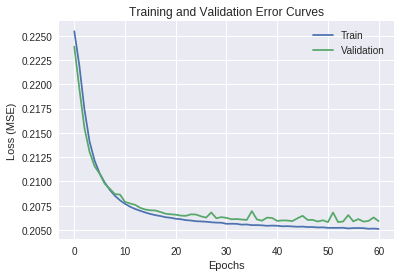

Matriz de confusão no conjunto de teste:
[[56683  7092]
 [24269  9256]]

Train Loss:       0.2052
Validation Loss:  0.2058

Performance no conjunto de teste:


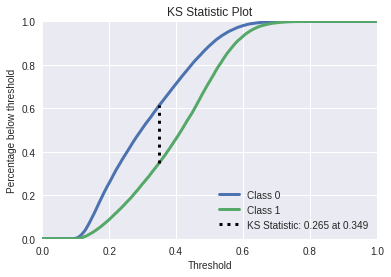


Accuracy:         0.6777
Recall:           0.2761
Precision:        0.5662
F1:               0.3712
AUROC:            0.6808
AUPR:             0.5102


In [0]:
out, model = credit_risk_analisys_model(X_train, y_train, X_val, y_val, p)
out_list.append(out)
model_list.append(model)
plot_training_error_curves(out)
run_test(out, model)

In [0]:
#Parâmetros desejados para grupo 1
p = {'lr': 0.5,
     'first_neuron':32,
     'neurons_in_hidden_layer': [],
     'activation_hidden_layer': [],
     'batch_size': 64,
     'optimizer': 'SGD',
     'loss': mean_squared_error,
     'last_activation': sigmoid}

Train on 194596 samples, validate on 97300 samples
Epoch 1/100000
 - 4s - loss: 0.2208 - acc: 0.6521 - val_loss: 0.2152 - val_acc: 0.6584
Epoch 2/100000
 - 4s - loss: 0.2129 - acc: 0.6615 - val_loss: 0.2117 - val_acc: 0.6643
Epoch 3/100000
 - 4s - loss: 0.2106 - acc: 0.6659 - val_loss: 0.2101 - val_acc: 0.6672
Epoch 4/100000
 - 4s - loss: 0.2093 - acc: 0.6675 - val_loss: 0.2092 - val_acc: 0.6689
Epoch 5/100000
 - 4s - loss: 0.2085 - acc: 0.6692 - val_loss: 0.2090 - val_acc: 0.6689
Epoch 6/100000
 - 4s - loss: 0.2080 - acc: 0.6700 - val_loss: 0.2082 - val_acc: 0.6706
Epoch 7/100000
 - 4s - loss: 0.2076 - acc: 0.6713 - val_loss: 0.2079 - val_acc: 0.6718
Epoch 8/100000
 - 4s - loss: 0.2073 - acc: 0.6722 - val_loss: 0.2075 - val_acc: 0.6723
Epoch 9/100000
 - 4s - loss: 0.2071 - acc: 0.6728 - val_loss: 0.2075 - val_acc: 0.6723
Epoch 10/100000
 - 4s - loss: 0.2069 - acc: 0.6727 - val_loss: 0.2072 - val_acc: 0.6729
Epoch 11/100000
 - 4s - loss: 0.2067 - acc: 0.6732 - val_loss: 0.2072 - val_ac

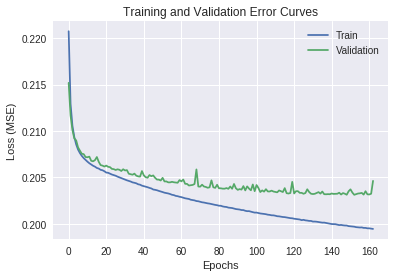

Matriz de confusão no conjunto de teste:
[[56049  7726]
 [23323 10202]]

Train Loss:       0.1997
Validation Loss:  0.2031

Performance no conjunto de teste:


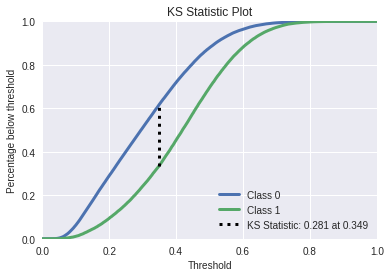


Accuracy:         0.6809
Recall:           0.3043
Precision:        0.5691
F1:               0.3966
AUROC:            0.6914
AUPR:             0.5204


In [0]:
out, model = credit_risk_analisys_model(X_train, y_train, X_val, y_val, p)
out_list.append(out)
model_list.append(model)
plot_training_error_curves(out)
run_test(out, model)

In [0]:
#Parâmetros desejados para grupo 2
p = {'lr': 1.0,
     'first_neuron':256,
     'neurons_in_hidden_layer': [],
     'activation_hidden_layer': [],
     'batch_size': 64,
     'optimizer': 'SGD',
     'loss': mean_squared_error,
     'last_activation': sigmoid}

Train on 194596 samples, validate on 97300 samples
Epoch 1/100000
 - 7s - loss: 0.2163 - acc: 0.6580 - val_loss: 0.2113 - val_acc: 0.6634
Epoch 2/100000
 - 7s - loss: 0.2100 - acc: 0.6661 - val_loss: 0.2098 - val_acc: 0.6662
Epoch 3/100000
 - 7s - loss: 0.2086 - acc: 0.6689 - val_loss: 0.2090 - val_acc: 0.6677
Epoch 4/100000
 - 7s - loss: 0.2080 - acc: 0.6704 - val_loss: 0.2081 - val_acc: 0.6705
Epoch 5/100000
 - 7s - loss: 0.2075 - acc: 0.6719 - val_loss: 0.2076 - val_acc: 0.6717
Epoch 6/100000
 - 7s - loss: 0.2072 - acc: 0.6725 - val_loss: 0.2073 - val_acc: 0.6726
Epoch 7/100000
 - 7s - loss: 0.2069 - acc: 0.6727 - val_loss: 0.2074 - val_acc: 0.6731
Epoch 8/100000
 - 7s - loss: 0.2067 - acc: 0.6741 - val_loss: 0.2075 - val_acc: 0.6720
Epoch 9/100000
 - 7s - loss: 0.2065 - acc: 0.6735 - val_loss: 0.2070 - val_acc: 0.6731
Epoch 10/100000
 - 7s - loss: 0.2064 - acc: 0.6742 - val_loss: 0.2068 - val_acc: 0.6740
Epoch 11/100000
 - 7s - loss: 0.2063 - acc: 0.6746 - val_loss: 0.2066 - val_ac

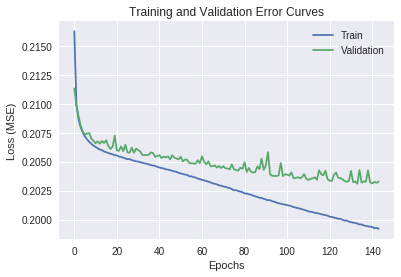

Matriz de confusão no conjunto de teste:
[[56217  7558]
 [23500 10025]]

Train Loss:       0.1997
Validation Loss:  0.2031

Performance no conjunto de teste:


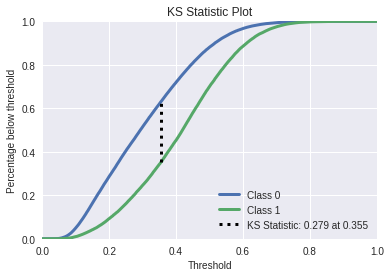


Accuracy:         0.6808
Recall:           0.2990
Precision:        0.5702
F1:               0.3923
AUROC:            0.6911
AUPR:             0.5207


In [0]:
out, model = credit_risk_analisys_model(X_train, y_train, X_val, y_val, p)
out_list.append(out)
model_list.append(model)
plot_training_error_curves(out)
run_test(out, model)

In [0]:
#Parâmetros desejados para grupo 3
p = {'lr': 0.75,
     'first_neuron':64,
     'neurons_in_hidden_layer': [128],
     'activation_hidden_layer': [relu],
     'batch_size': 64,
     'optimizer': 'SGD',
     'loss': mean_squared_error,
     'last_activation': sigmoid}

Train on 194596 samples, validate on 97300 samples
Epoch 1/100000
 - 5s - loss: 0.2211 - acc: 0.6553 - val_loss: 0.2173 - val_acc: 0.6560
Epoch 2/100000
 - 5s - loss: 0.2151 - acc: 0.6589 - val_loss: 0.2135 - val_acc: 0.6602
Epoch 3/100000
 - 5s - loss: 0.2122 - acc: 0.6629 - val_loss: 0.2114 - val_acc: 0.6635
Epoch 4/100000
 - 5s - loss: 0.2103 - acc: 0.6666 - val_loss: 0.2099 - val_acc: 0.6667
Epoch 5/100000
 - 5s - loss: 0.2092 - acc: 0.6688 - val_loss: 0.2092 - val_acc: 0.6685
Epoch 6/100000
 - 5s - loss: 0.2083 - acc: 0.6701 - val_loss: 0.2084 - val_acc: 0.6699
Epoch 7/100000
 - 5s - loss: 0.2077 - acc: 0.6712 - val_loss: 0.2079 - val_acc: 0.6709
Epoch 8/100000
 - 5s - loss: 0.2073 - acc: 0.6720 - val_loss: 0.2076 - val_acc: 0.6715
Epoch 9/100000
 - 5s - loss: 0.2069 - acc: 0.6726 - val_loss: 0.2072 - val_acc: 0.6725
Epoch 10/100000
 - 5s - loss: 0.2066 - acc: 0.6735 - val_loss: 0.2074 - val_acc: 0.6726
Epoch 11/100000
 - 5s - loss: 0.2063 - acc: 0.6743 - val_loss: 0.2068 - val_ac

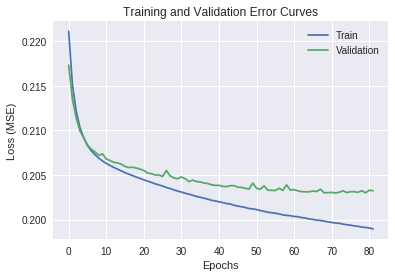

Matriz de confusão no conjunto de teste:
[[56384  7391]
 [23709  9816]]

Train Loss:       0.1996
Validation Loss:  0.2030

Performance no conjunto de teste:


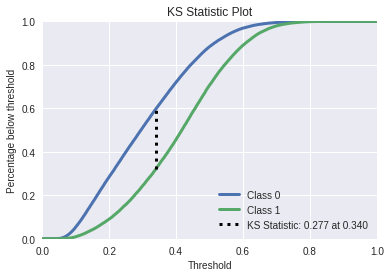


Accuracy:         0.6804
Recall:           0.2928
Precision:        0.5705
F1:               0.3870
AUROC:            0.6903
AUPR:             0.5199


In [0]:
out, model = credit_risk_analisys_model(X_train, y_train, X_val, y_val, p)
out_list.append(out)
model_list.append(model)
plot_training_error_curves(out)
run_test(out, model)

In [0]:
#Parâmetros desejados para grupo 4
p = {'lr': 1.5,
     'first_neuron':16,
     'neurons_in_hidden_layer': [32],
     'activation_hidden_layer': [softmax],
     'batch_size': 64,
     'optimizer': 'SGD',
     'loss': mean_squared_error,
     'last_activation': sigmoid}

Train on 194596 samples, validate on 97300 samples
Epoch 1/100000
 - 4s - loss: 0.2292 - acc: 0.6518 - val_loss: 0.2258 - val_acc: 0.6554
Epoch 2/100000
 - 4s - loss: 0.2258 - acc: 0.6555 - val_loss: 0.2257 - val_acc: 0.6554
Epoch 3/100000
 - 4s - loss: 0.2257 - acc: 0.6555 - val_loss: 0.2257 - val_acc: 0.6554
Epoch 4/100000
 - 4s - loss: 0.2257 - acc: 0.6555 - val_loss: 0.2257 - val_acc: 0.6554
Epoch 5/100000
 - 4s - loss: 0.2256 - acc: 0.6555 - val_loss: 0.2256 - val_acc: 0.6554
Epoch 6/100000
 - 4s - loss: 0.2256 - acc: 0.6555 - val_loss: 0.2256 - val_acc: 0.6554
Epoch 7/100000
 - 4s - loss: 0.2255 - acc: 0.6555 - val_loss: 0.2255 - val_acc: 0.6554
Epoch 8/100000
 - 4s - loss: 0.2255 - acc: 0.6555 - val_loss: 0.2255 - val_acc: 0.6554
Epoch 9/100000
 - 4s - loss: 0.2254 - acc: 0.6555 - val_loss: 0.2254 - val_acc: 0.6554
Epoch 10/100000
 - 4s - loss: 0.2254 - acc: 0.6555 - val_loss: 0.2253 - val_acc: 0.6554
Epoch 11/100000
 - 4s - loss: 0.2253 - acc: 0.6555 - val_loss: 0.2252 - val_ac

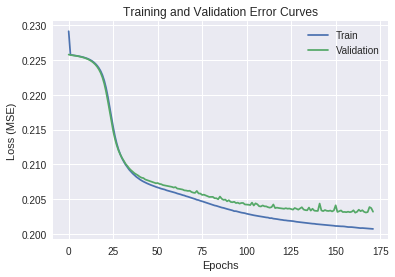

Matriz de confusão no conjunto de teste:
[[56001  7774]
 [23233 10292]]

Train Loss:       0.2009
Validation Loss:  0.2031

Performance no conjunto de teste:


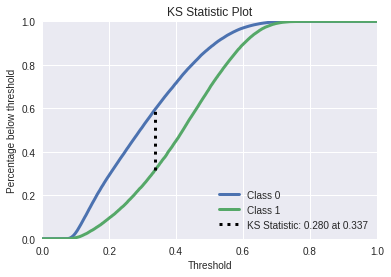


Accuracy:         0.6813
Recall:           0.3070
Precision:        0.5697
F1:               0.3990
AUROC:            0.6919
AUPR:             0.5215


In [0]:
out, model = credit_risk_analisys_model(X_train, y_train, X_val, y_val, p)
out_list.append(out)
model_list.append(model)
plot_training_error_curves(out)
run_test(out, model)

In [0]:
#Parâmetros desejados para grupo 5
p = {'lr': 2.0,
     'first_neuron':32,
     'neurons_in_hidden_layer': [32, 128],
     'activation_hidden_layer': [relu, tanh],
     'batch_size': 64,
     'optimizer': 'SGD',
     'loss': mean_squared_error,
     'last_activation': sigmoid}

Train on 194596 samples, validate on 97300 samples
Epoch 1/100000
 - 5s - loss: 0.2252 - acc: 0.6521 - val_loss: 0.2216 - val_acc: 0.6555
Epoch 2/100000
 - 4s - loss: 0.2180 - acc: 0.6565 - val_loss: 0.2150 - val_acc: 0.6580
Epoch 3/100000
 - 4s - loss: 0.2130 - acc: 0.6612 - val_loss: 0.2119 - val_acc: 0.6631
Epoch 4/100000
 - 4s - loss: 0.2107 - acc: 0.6651 - val_loss: 0.2104 - val_acc: 0.6660
Epoch 5/100000
 - 4s - loss: 0.2095 - acc: 0.6673 - val_loss: 0.2094 - val_acc: 0.6680
Epoch 6/100000
 - 4s - loss: 0.2087 - acc: 0.6691 - val_loss: 0.2091 - val_acc: 0.6688
Epoch 7/100000
 - 4s - loss: 0.2082 - acc: 0.6700 - val_loss: 0.2084 - val_acc: 0.6709
Epoch 8/100000
 - 4s - loss: 0.2078 - acc: 0.6714 - val_loss: 0.2081 - val_acc: 0.6711
Epoch 9/100000
 - 4s - loss: 0.2074 - acc: 0.6724 - val_loss: 0.2080 - val_acc: 0.6707
Epoch 10/100000
 - 4s - loss: 0.2071 - acc: 0.6726 - val_loss: 0.2079 - val_acc: 0.6712
Epoch 11/100000
 - 4s - loss: 0.2068 - acc: 0.6737 - val_loss: 0.2072 - val_ac

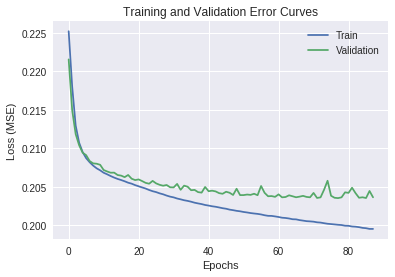

Matriz de confusão no conjunto de teste:
[[55310  8465]
 [22775 10750]]

Train Loss:       0.2001
Validation Loss:  0.2035

Performance no conjunto de teste:


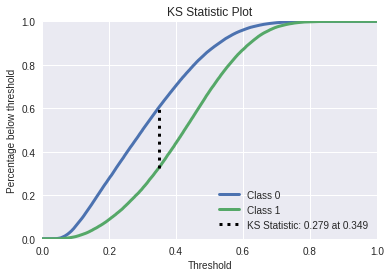


Accuracy:         0.6789
Recall:           0.3207
Precision:        0.5595
F1:               0.4077
AUROC:            0.6900
AUPR:             0.5192


In [0]:
out, model = credit_risk_analisys_model(X_train, y_train, X_val, y_val, p)
out_list.append(out)
model_list.append(model)
plot_training_error_curves(out)
run_test(out, model)

In [0]:
#Parâmetros desejados para grupo 6
p = {'lr': 3.0,
     'first_neuron':64,
     'neurons_in_hidden_layer': [128, 128],
     'activation_hidden_layer': [sigmoid, sigmoid],
     'batch_size': 64,
     'optimizer': 'SGD',
     'loss': mean_squared_error,
     'last_activation': sigmoid}

Train on 194596 samples, validate on 97300 samples
Epoch 1/100000
 - 6s - loss: 0.2269 - acc: 0.6526 - val_loss: 0.2257 - val_acc: 0.6554
Epoch 2/100000
 - 6s - loss: 0.2254 - acc: 0.6555 - val_loss: 0.2252 - val_acc: 0.6554
Epoch 3/100000
 - 6s - loss: 0.2250 - acc: 0.6555 - val_loss: 0.2247 - val_acc: 0.6554
Epoch 4/100000
 - 6s - loss: 0.2244 - acc: 0.6555 - val_loss: 0.2241 - val_acc: 0.6554
Epoch 5/100000
 - 6s - loss: 0.2237 - acc: 0.6555 - val_loss: 0.2234 - val_acc: 0.6554
Epoch 6/100000
 - 6s - loss: 0.2228 - acc: 0.6555 - val_loss: 0.2222 - val_acc: 0.6554
Epoch 7/100000
 - 6s - loss: 0.2216 - acc: 0.6555 - val_loss: 0.2209 - val_acc: 0.6554
Epoch 8/100000
 - 6s - loss: 0.2200 - acc: 0.6555 - val_loss: 0.2192 - val_acc: 0.6554
Epoch 9/100000
 - 5s - loss: 0.2183 - acc: 0.6555 - val_loss: 0.2174 - val_acc: 0.6554
Epoch 10/100000
 - 6s - loss: 0.2164 - acc: 0.6556 - val_loss: 0.2156 - val_acc: 0.6566
Epoch 11/100000
 - 6s - loss: 0.2146 - acc: 0.6571 - val_loss: 0.2140 - val_ac

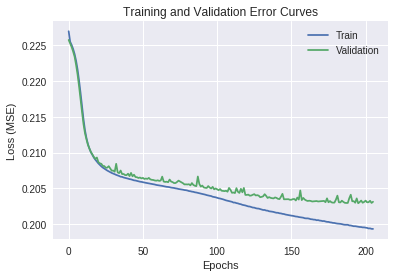

Matriz de confusão no conjunto de teste:
[[55948  7827]
 [23223 10302]]

Train Loss:       0.1997
Validation Loss:  0.2029

Performance no conjunto de teste:


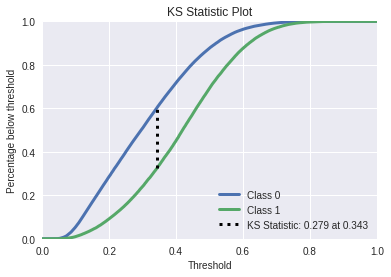


Accuracy:         0.6809
Recall:           0.3073
Precision:        0.5683
F1:               0.3989
AUROC:            0.6917
AUPR:             0.5217


In [0]:
out, model = credit_risk_analisys_model(X_train, y_train, X_val, y_val, p)
out_list.append(out)
model_list.append(model)
plot_training_error_curves(out)
run_test(out, model)

In [0]:
#Parâmetros desejados para grupo 7
p = {'lr': 3.5,
     'first_neuron':32,
     'neurons_in_hidden_layer': [64, 128, 256],
     'activation_hidden_layer': [sigmoid, sigmoid, sigmoid],
     'batch_size': 64,
     'optimizer': 'SGD',
     'loss': mean_squared_error,
     'last_activation': sigmoid}

Train on 194596 samples, validate on 97300 samples
Epoch 1/100000
 - 7s - loss: 0.2261 - acc: 0.6555 - val_loss: 0.2259 - val_acc: 0.6554
Epoch 2/100000
 - 6s - loss: 0.2260 - acc: 0.6555 - val_loss: 0.2258 - val_acc: 0.6554
Epoch 3/100000
 - 6s - loss: 0.2260 - acc: 0.6555 - val_loss: 0.2262 - val_acc: 0.6554
Epoch 4/100000
 - 6s - loss: 0.2260 - acc: 0.6555 - val_loss: 0.2259 - val_acc: 0.6554
Epoch 5/100000
 - 6s - loss: 0.2259 - acc: 0.6555 - val_loss: 0.2258 - val_acc: 0.6554
Epoch 6/100000
 - 6s - loss: 0.2259 - acc: 0.6555 - val_loss: 0.2261 - val_acc: 0.6554
Epoch 7/100000
 - 6s - loss: 0.2259 - acc: 0.6555 - val_loss: 0.2258 - val_acc: 0.6554
Epoch 8/100000
 - 6s - loss: 0.2259 - acc: 0.6555 - val_loss: 0.2261 - val_acc: 0.6554
Epoch 9/100000
 - 7s - loss: 0.2259 - acc: 0.6555 - val_loss: 0.2258 - val_acc: 0.6554
Epoch 10/100000
 - 6s - loss: 0.2259 - acc: 0.6555 - val_loss: 0.2264 - val_acc: 0.6554
Epoch 11/100000
 - 6s - loss: 0.2259 - acc: 0.6555 - val_loss: 0.2258 - val_ac

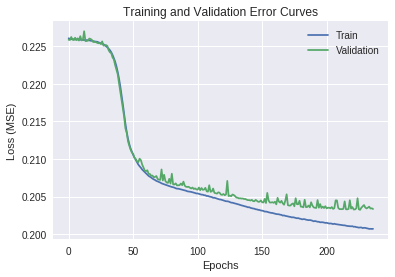

Matriz de confusão no conjunto de teste:
[[55979  7796]
 [23247 10278]]

Train Loss:       0.2009
Validation Loss:  0.2032

Performance no conjunto de teste:


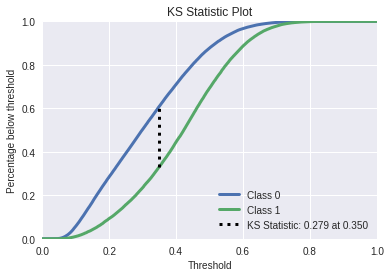


Accuracy:         0.6810
Recall:           0.3066
Precision:        0.5687
F1:               0.3984
AUROC:            0.6910
AUPR:             0.5208


In [0]:
out, model = credit_risk_analisys_model(X_train, y_train, X_val, y_val, p)
out_list.append(out)
model_list.append(model)
plot_training_error_curves(out)
run_test(out, model)

In [0]:
#Parâmetros desejados para grupo 8
p = {'lr': 4.0,
     'first_neuron':128,
     'neurons_in_hidden_layer': [128, 256, 128],
     'activation_hidden_layer': [tanh, sigmoid, relu],
     'batch_size': 64,
     'optimizer': 'SGD',
     'loss': mean_squared_error,
     'last_activation': sigmoid}

Train on 194596 samples, validate on 97300 samples
Epoch 1/100000
 - 11s - loss: 0.2240 - acc: 0.6554 - val_loss: 0.2217 - val_acc: 0.6554
Epoch 2/100000
 - 10s - loss: 0.2192 - acc: 0.6558 - val_loss: 0.2167 - val_acc: 0.6560
Epoch 3/100000
 - 10s - loss: 0.2144 - acc: 0.6595 - val_loss: 0.2133 - val_acc: 0.6597
Epoch 4/100000
 - 10s - loss: 0.2116 - acc: 0.6642 - val_loss: 0.2119 - val_acc: 0.6643
Epoch 5/100000
 - 10s - loss: 0.2101 - acc: 0.6655 - val_loss: 0.2097 - val_acc: 0.6671
Epoch 6/100000
 - 10s - loss: 0.2092 - acc: 0.6676 - val_loss: 0.2089 - val_acc: 0.6684
Epoch 7/100000
 - 10s - loss: 0.2086 - acc: 0.6693 - val_loss: 0.2093 - val_acc: 0.6676
Epoch 8/100000
 - 10s - loss: 0.2081 - acc: 0.6699 - val_loss: 0.2081 - val_acc: 0.6701
Epoch 9/100000
 - 9s - loss: 0.2077 - acc: 0.6711 - val_loss: 0.2085 - val_acc: 0.6702
Epoch 10/100000
 - 10s - loss: 0.2074 - acc: 0.6715 - val_loss: 0.2102 - val_acc: 0.6653
Epoch 11/100000
 - 10s - loss: 0.2072 - acc: 0.6722 - val_loss: 0.208

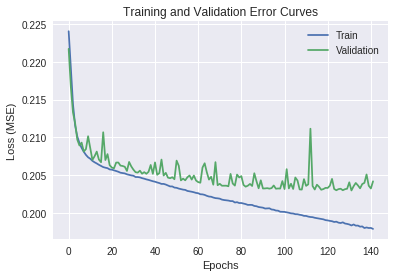

Matriz de confusão no conjunto de teste:
[[56393  7382]
 [23652  9873]]

Train Loss:       0.1983
Validation Loss:  0.2030

Performance no conjunto de teste:


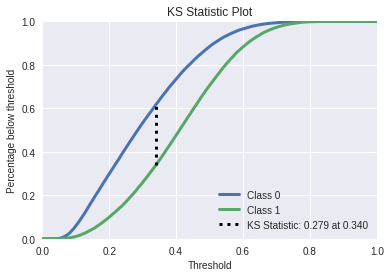


Accuracy:         0.6810
Recall:           0.2945
Precision:        0.5722
F1:               0.3889
AUROC:            0.6911
AUPR:             0.5218


In [0]:
out, model = credit_risk_analisys_model(X_train, y_train, X_val, y_val, p)
out_list.append(out)
model_list.append(model)
plot_training_error_curves(out)
run_test(out, model)

## Ensamble de MLP's

In [0]:
input_dim=X_train.shape[1]

In [0]:
def create_sklearn_compatible_model_1():
    model = Sequential()
    model.add(Dense(16, activation='tanh', input_dim=input_dim))
    model.add(Dense(32, activation='softmax', input_dim=input_dim))
    model.add(Dense(1, activation=sigmoid))
    model.compile(optimizer='SGD', loss=mean_squared_error)
    return model

In [0]:
def create_sklearn_compatible_model_2():
    model = Sequential()
    model.add(Dense(64, activation='tanh', input_dim=input_dim))
    model.add(Dense(128, activation=sigmoid, input_dim=input_dim))
    model.add(Dense(128, activation=sigmoid, input_dim=input_dim))
    model.add(Dense(1, activation=sigmoid))
    model.compile(optimizer='SGD', loss=mean_squared_error)
    return model

In [0]:
def create_sklearn_compatible_model_3():
    model = Sequential()
    model.add(Dense(32, activation='tanh', input_dim=input_dim))
    model.add(Dense(1, activation=sigmoid))
    model.compile(optimizer='SGD', loss=mean_squared_error)
    return model

In [0]:

mlp_clf_1 = KerasClassifier(build_fn=create_sklearn_compatible_model_1, 
                          batch_size=64, epochs=172,
                          verbose=2)

mlp_clf_2 = KerasClassifier(build_fn=create_sklearn_compatible_model_2, 
                          batch_size=64, epochs=206,
                          verbose=2)

mlp_clf_3 = KerasClassifier(build_fn=create_sklearn_compatible_model_3, 
                          batch_size=64, epochs=163,
                          verbose=2)

Epoch 1/172
 - 5s - loss: 0.2291
Epoch 2/172
 - 4s - loss: 0.2258
Epoch 3/172
 - 4s - loss: 0.2258
Epoch 4/172
 - 4s - loss: 0.2257
Epoch 5/172
 - 4s - loss: 0.2256
Epoch 6/172
 - 4s - loss: 0.2255
Epoch 7/172
 - 4s - loss: 0.2254
Epoch 8/172
 - 4s - loss: 0.2253
Epoch 9/172
 - 4s - loss: 0.2252
Epoch 10/172
 - 4s - loss: 0.2250
Epoch 11/172
 - 4s - loss: 0.2248
Epoch 12/172
 - 4s - loss: 0.2245
Epoch 13/172
 - 4s - loss: 0.2240
Epoch 14/172
 - 4s - loss: 0.2234
Epoch 15/172
 - 4s - loss: 0.2225
Epoch 16/172
 - 4s - loss: 0.2214
Epoch 17/172
 - 4s - loss: 0.2201
Epoch 18/172
 - 4s - loss: 0.2188
Epoch 19/172
 - 4s - loss: 0.2174
Epoch 20/172
 - 4s - loss: 0.2160
Epoch 21/172
 - 4s - loss: 0.2148
Epoch 22/172
 - 4s - loss: 0.2137
Epoch 23/172
 - 4s - loss: 0.2128
Epoch 24/172
 - 4s - loss: 0.2122
Epoch 25/172
 - 4s - loss: 0.2116
Epoch 26/172
 - 4s - loss: 0.2111
Epoch 27/172
 - 4s - loss: 0.2107
Epoch 28/172
 - 4s - loss: 0.2102
Epoch 29/172
 - 4s - loss: 0.2099
Epoch 30/172
 - 4s - lo

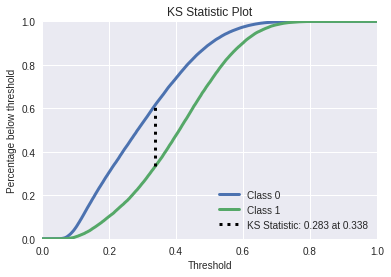


Accuracy:         0.6836
Recall:           0.2812
Precision:        0.5851
F1:               0.3798
AUROC:            0.6941
AUPR:             0.5284


In [0]:
ens_clf = VotingClassifier([('mlp_1', mlp_clf_1), ('mlp_2', mlp_clf_2), ('mlp_3', mlp_clf_3)], voting='soft')

ens_clf.fit(X_train, y_train)
ens_pred_class = ens_clf.predict(X_val)
ens_pred_scores = ens_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, ens_pred_class, ens_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

Epoch 1/172
 - 5s - loss: 0.2291
Epoch 2/172
 - 4s - loss: 0.2258
Epoch 3/172
 - 4s - loss: 0.2257
Epoch 4/172
 - 4s - loss: 0.2256
Epoch 5/172
 - 4s - loss: 0.2256
Epoch 6/172
 - 4s - loss: 0.2255
Epoch 7/172
 - 4s - loss: 0.2254
Epoch 8/172
 - 4s - loss: 0.2253
Epoch 9/172
 - 4s - loss: 0.2252
Epoch 10/172
 - 4s - loss: 0.2250
Epoch 11/172
 - 4s - loss: 0.2249
Epoch 12/172
 - 4s - loss: 0.2247
Epoch 13/172
 - 4s - loss: 0.2245
Epoch 14/172
 - 4s - loss: 0.2243
Epoch 15/172
 - 4s - loss: 0.2240
Epoch 16/172
 - 4s - loss: 0.2237
Epoch 17/172
 - 4s - loss: 0.2233
Epoch 18/172
 - 4s - loss: 0.2227
Epoch 19/172
 - 4s - loss: 0.2220
Epoch 20/172
 - 4s - loss: 0.2210
Epoch 21/172
 - 4s - loss: 0.2198
Epoch 22/172
 - 4s - loss: 0.2182
Epoch 23/172
 - 4s - loss: 0.2166
Epoch 24/172
 - 4s - loss: 0.2152
Epoch 25/172
 - 4s - loss: 0.2140
Epoch 26/172
 - 4s - loss: 0.2130
Epoch 27/172
 - 4s - loss: 0.2123
Epoch 28/172
 - 4s - loss: 0.2117
Epoch 29/172
 - 4s - loss: 0.2111
Epoch 30/172
 - 4s - lo

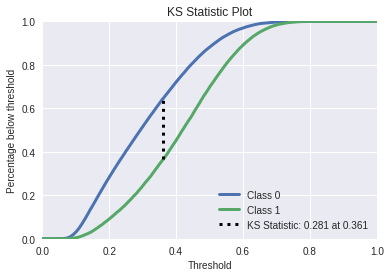


Accuracy:         0.6819
Recall:           0.3026
Precision:        0.5725
F1:               0.3960
AUROC:            0.6933
AUPR:             0.5271


In [0]:
ens_clf = VotingClassifier([('mlp_1', mlp_clf_1), ('mlp_2', mlp_clf_2), ('mlp_3', mlp_clf_3)], voting='soft', weights=[3,2,1])

ens_clf.fit(X_train, y_train)
ens_pred_class = ens_clf.predict(X_val)
ens_pred_scores = ens_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, ens_pred_class, ens_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)